# Preference Learning
#### Michał Ciesielski 145325, Paweł Chumski 144392
Analizowanym przez nas zbiorem danych jest zbiór 'car evaluation'. Zawiera on aż 1728 alternatyw przypisanych do 4 możliwych klas decyzyjnych. Wartości tych klas (liczby od 1 do 4) przypisują kolejnym wierszom reprezentującym różne modele samochodów odpowiednią jakość danego auta (odpowiednio nieakceptowalny, akceptowalny, dobry, bardzo dobry). Odpowiednie przypadki reprezentowane są na podstawie wartości na 6 atrybutach warunkowych, którym można przypisać następujące znaczenie: cena zakupu (kryterium typu koszt), koszt utrzymania (koszt), liczba drzwi (zysk), pojemność - liczba osób (zysk), wielkość bagażnika (zysk), bezpieczeństwo (zysk). Wartości porządkowe tych atrybutów zostały przetransformowane do wartości numerycznych w skali od 0 do 1 w zależności od charakteru danego kryterium. Dla tego problemu wytrenowane zostaną 3 modele:
* interpretowalny model rankSVM
* interpretowalny model ANN-Ch-Constr.
* złożony model sieci neuronowej zawierający kilka warstw ukrytych.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from anchor import utils
from anchor import anchor_tabular
import torch
import torch.nn as nn
import torch.nn.functional as F
from skorch import NeuralNetBinaryClassifier

from helpers import *

In [41]:
def TransformRowDiff(d):
    a = np.lib.stride_tricks.as_strided(
        d,
        (d.shape[0], d.shape[0], d.shape[1]),
        (d.itemsize * d.shape[1], 0, d.itemsize),
    )
    a = a.reshape(-1, d.shape[1])
    
    b = np.lib.stride_tricks.as_strided(
        d,
        (d.shape[0], d.shape[0], d.shape[1]),
        (0, d.itemsize * d.shape[1], d.itemsize),
    )
    b = b.reshape(-1, d.shape[1])
    return a - b

In [42]:
path = "data/car evaluation.csv"
data = pd.read_csv(path, header=None)
data.columns = ['buying', 'maintenance', 'doors_number', 'persons_number', 'lug_boot', 'safety', 'decision']
print(data[data['decision'] == 1].shape[0])
print(data[data['decision'] != 1].shape[0])

1210
518


Ze względu na charakter rozpatrywanego problemu oraz jego uogólnienia, binaryzujemy wartości atrybutu decyzyjnego. Przedstawiony wyżej rozkład wartości sugeruje, że w zbiorze znajduje się zdecydowanie więcej wartości 1 tego atrybutu (unacceptable) niż pozostałych. W tym kontekście od teraz wartość 0 atrybutu decyzyjnego będzie sugerowała, aby danego auta nie kupować, wartość 1 natomiast będzie oznaczała, że dane auto spełnia kryteria decydenta odnośnie do jego zakupu.

## Model rankSVM

In [43]:
target_map = {1: 0, 2: 1, 3: 1, 4: 1}
criteria_name = 'decision'
data[criteria_name] = data[criteria_name].apply(lambda x: target_map[x])
data = data.drop_duplicates()
data_input = data.drop(columns=[criteria_name])
data_target = data[criteria_name]

data_input = data_input.values

X_train, X_test, y_train, y_test = train_test_split(
    data_input, data_target.values, test_size=0.2, random_state=1234
)

X_train = TransformRowDiff(X_train)
X_test = TransformRowDiff(X_test)
y_train = TransformRowDiff(y_train.reshape(-1, 1))[:, 0]
y_test = TransformRowDiff(y_test.reshape(-1, 1))[:, 0]

X_train = X_train[y_train != 0]
y_train = y_train[y_train != 0]


X_test = X_test[y_test != 0]
y_test = y_test[y_test != 0]

In [44]:
np.unique(y_train)

array([-1,  1], dtype=int64)

In [45]:
model = svm.LinearSVC()
model.fit(X_train,y_train)

LinearSVC()

In [46]:
print(model)

LinearSVC()


In [47]:
y_pred = model.predict(X_train)
out = np.dot(X_train, model.coef_.T)
print("Accuracy train:\t%.2f%%" % (accuracy_score(y_train, y_pred) * 100.0))
print("F1 train:\t%.2f%%" % (f1_score(y_train, y_pred) * 100.0))
print("AUC train: \t%.2f%%" % (roc_auc_score(y_train, out) * 100.0))
print()

y_pred = model.predict(X_test)
out = np.dot(X_test, model.coef_.T)
print("Accuracy test:\t%.2f%%" % (accuracy_score(y_test, y_pred) * 100.0))
print("F1 test:\t%.2f%%" % (f1_score(y_test, y_pred) * 100.0))
print("AUC test: \t%.2f%%" % (roc_auc_score(y_test, out) * 100.0))

Accuracy train:	93.59%
F1 train:	93.59%
AUC train: 	98.54%

Accuracy test:	94.45%
F1 test:	94.45%
AUC test: 	98.93%


In [52]:
print(X_train.round(4))
print(y_train)

[[-0.6667  0.3333  0.     -1.      0.      0.5   ]
 [-1.      0.      0.3333 -0.5     0.      0.    ]
 [ 0.     -0.3333  0.3333 -1.      0.5     0.    ]
 ...
 [ 0.     -0.3333  0.3333 -0.5     0.      0.    ]
 [ 0.     -0.3333  0.6667 -0.5    -0.5     0.5   ]
 [ 0.3333  0.      0.3333 -0.5     0.      0.5   ]]
[-1 -1 -1 ... -1 -1 -1]


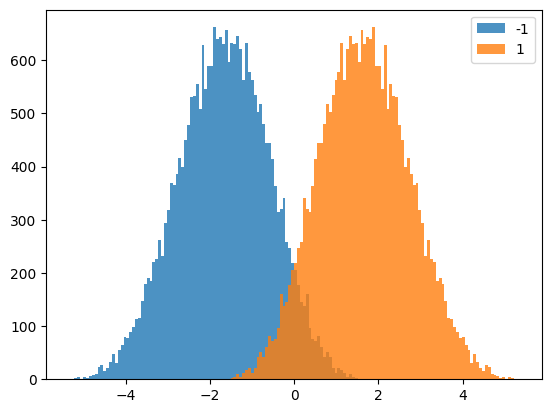

In [49]:
plt.hist(out[y_test==-1], alpha=0.8, bins=100, label="-1")
plt.hist(out[y_test==1], alpha=0.8, bins=100, label="1")
plt.legend()
plt.show()

In [53]:
w = model.coef_[0]
print(f'coef {w.round(4)}')
b = model.intercept_[0]
print(f'intercept {b.round(4)}')

coef [-0.834  -0.7933  0.2493  1.4616  0.5564  1.7232]
intercept -0.0


In [54]:
def plotDensity(X_train, y_train, c_1, c_2, samples=10000):
    axes = sns.jointplot(
        x=X_train[:samples, c_1],
        y=X_train[:samples, c_2],
        hue=y_train[:samples],
        kind="kde",
        palette=["green", "red"],
        fill=True,
        alpha=0.5,
    )
    x_points = np.linspace(-1, 1)
    y_points = -(w[c_1] / w[c_2]) * x_points - b / w[c_2]
    x_points = x_points[np.logical_and(y_points < 1, y_points > -1)]
    y_points = y_points[np.logical_and(y_points < 1, y_points > -1)]
    axes.ax_joint.plot(x_points, y_points, c="b")
    axes.ax_joint.set_xlabel(f"kryterium: {c_1}")
    axes.ax_joint.set_ylabel(f"kryterium: {c_2}")

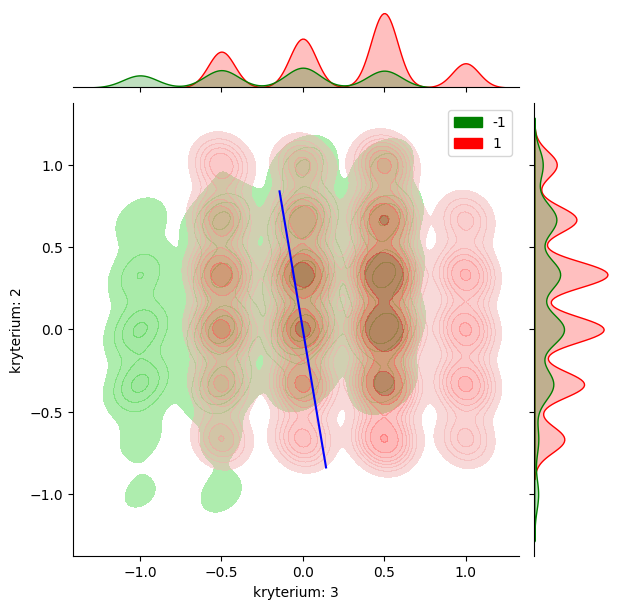

In [55]:
c_1 = 3
c_2 = 2
plotDensity(X_train, y_train, c_1, c_2, samples=10000)

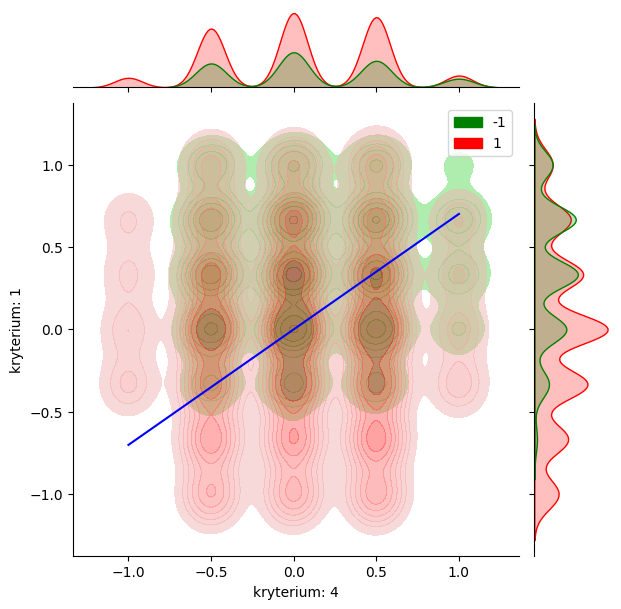

In [56]:
c_1 = 4
c_2 = 1
plotDensity(X_train, y_train, c_1, c_2, samples=10000)

## Interpretacja modelu
Na podstawie uzyskanych parametrów można stwierdzić, że użytkownicy przy ocenie samochodu pod kątem ewentualnego zakupu, biorą pod uwagę przede wszystkim jego bezpieczeństwo. Również dość istotnym parametrem jest kwestia maksymalnej liczby osób, które dany pojazd może pomieścić. Koszty utrzymania oraz zakupu danego pojazdu także są dość ważne. Najmniej istotnym kryterium jest liczba drzwi, w które dany samochód jest wyposażony. Decydujący wpływ zdaje się mieć kryterium bezpieczeństwa - żaden z decydentów nie będzie skłonny do zakupu auta, które jest skrajnie niebezpieczne. Jednak określenie "skrajny" jest w tym kontekście najistotniejsze - każde kryterium w różny sposób wpływa na ostateczną decyzję i żadnego z nich nie można w tym przypadku wykluczyć. Jak można zauważyć na powyższych wykresach poszczególne kryteria nie są separowalne liniowo w 2-wymiarowej przestrzeni - nie sposób odnaleźć progi decyzyjne. Istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji - żadne z kryterium nie jest w pełni decydujące.

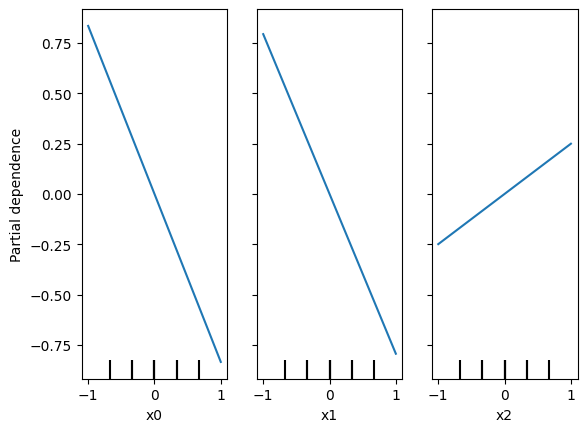

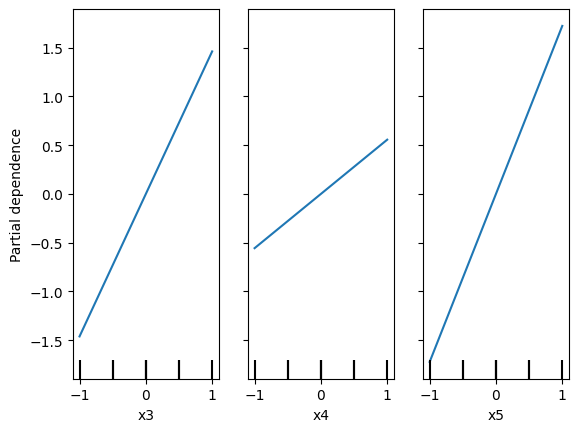

In [57]:
features_1 = [0, 1, 2]
PartialDependenceDisplay.from_estimator(model, X_train, features_1)
features_2 = [3, 4, 5]
PartialDependenceDisplay.from_estimator(model, X_train, features_2)

In [58]:
permutation_importance_result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=42)
print(permutation_importance_result.importances_mean.round(4))
print(permutation_importance_result.importances_std.round(4))

[0.0406 0.0357 0.0031 0.1486 0.0201 0.2267]
[0.0001 0.0002 0.0001 0.0004 0.0001 0.0005]


Wyniki uzyskane z powyższych technik interpretacji modelu potwierdzają wykonaną w poprzednim punkcie analizę.
## Wyjaśnienie decyzji

In [62]:
chosen_variants_input = np.array([X_train[256], X_train[367], X_train[1279]])
chosen_variants_target = np.array([y_train[256], y_train[367], y_train[1279]])
print(chosen_variants_input.round(4))
print(chosen_variants_target)

[[-0.3333 -0.3333  0.6667 -1.     -0.5     0.    ]
 [-1.      0.3333  0.3333 -1.     -0.5     0.    ]
 [ 0.6667 -0.6667  0.6667  0.      0.5    -0.5   ]]
[-1 -1  1]


Ze względu na specyfikę analizowanej metody trudno jest analitycznie wyznaczyć kluczową zmianę. Dla każdego wariantu obliczana jest różnica pomiędzy wszystkimi wariantami z przeciwnej klasy. Opierając się na tych różnicach stwierdzamy, że gdy jest ona dodatnia dla atrybutu 'safety', powyższe warianty 1 i 2 będą należały do klasy 1.

In [63]:
chosen_variants_input[0][5], chosen_variants_input[1][5] = 1, 1
y_probe = model.predict(chosen_variants_input)
print(y_probe[0], y_probe[1]) 

1 1


Uzyskane wyniki zgadzają się z przewidywaniami teoretycznymi.

In [64]:
explainer = anchor_tabular.AnchorTabularExplainer(
    [0, 1],
    ['buying', 'maintenance', 'doors_number', 'persons_number', 'lug_boot', 'safety'],
    X_train)

In [65]:
for index in [256, 367, 1279]:
    print(X_test[index].round(4))
    np.random.seed(1)
    print('Prediction: ', explainer.class_names[model.predict(X_test[index].reshape(1, -1))[0]])
    exp = explainer.explain_instance(X_test[index], model.predict, threshold=0.95)

    print('Anchor: %s' % (' AND '.join(exp.names())))
    print('Precision: %.2f' % exp.precision())
    print('Coverage: %.2f' % exp.coverage())

[ 1.  0.  0. -1.  0.  0.]
Prediction:  1
Anchor: persons_number <= -0.50 AND safety <= 0.00 AND buying > 0.33
Precision: 1.00
Coverage: 0.07
[0.     0.     0.6667 1.     1.     1.    ]
Prediction:  1
Anchor: safety > 0.50 AND persons_number > 0.00
Precision: 1.00
Coverage: 0.07
[-1.     -0.6667  0.3333  0.     -0.5     0.5   ]
Prediction:  1
Anchor: safety > 0.00 AND maintenance <= -0.33
Precision: 0.97
Coverage: 0.11


Powyższa analiza dla kilku wariantów potwierdza słuszność przeprowadzonych analiz. Kryterium 'safety' jest zdecydowanie najważniejszym kryterium pozwalającym zaklasyfikować niektóre warianty do odpowiedniej klasy decyzyjnej.

## Model ANN-Ch-Constr.

In [2]:
class LinearGreaterThanZero(nn.Linear):
    def __init__(self, in_features, bias=False, min_w=0.0000001):
        super().__init__(in_features, 1, bias)
        self.is_bias = bias
        self.min_w = min_w
        if bias:
            nn.init.uniform_(self.bias, self.min_w, 1.0)
        else:
            self.bias = None

    def reset_parameters(self):
        nn.init.uniform_(self.weight, 0.1, 1.0)

    def w(self):
        with torch.no_grad():
            self.weight.data[self.weight.data < 0] = self.min_w
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), self.bias)

In [3]:
class LinearInteraction(nn.Linear):
    def __init__(self, in_features, criterion_layer):
        super().__init__(((in_features - 1) * in_features) // 2, 1, False)
        self.in_features = in_features
        self.criterion_layer = criterion_layer

    def reset_parameters(self):
        nn.init.normal_(self.weight, 0.0, 0.1)

    def w(self):
        with torch.no_grad():
            w_i = 0
            w = self.criterion_layer.w()
            for i in range(self.in_features):
                for j in range(i + 1, self.in_features):
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, i]
                    )
                    self.weight.data[:, w_i] = torch.max(
                        self.weight.data[:, w_i], -w[:, j]
                    )
                    w_i += 1
        return self.weight

    def forward(self, input):
        return F.linear(input, self.w(), None)

In [4]:
class ThresholdLayer(nn.Module):
    def __init__(self, threshold=None, requires_grad=True):
        super().__init__()
        if threshold is None:
            self.threshold = nn.Parameter(
                torch.FloatTensor(1).uniform_(0.1, 0.5), requires_grad=requires_grad
            )
        else:
            self.threshold = nn.Parameter(
                torch.FloatTensor([threshold]), requires_grad=requires_grad
            )

    def forward(self, x):
        return x - self.threshold

In [5]:
class ChoquetConstrained(nn.Module):
    def __init__(self, criteria_nr, **kwargs):
        super().__init__()
        self.criteria_nr = criteria_nr
        self.criteria_layer = LinearGreaterThanZero(criteria_nr)
        self.interaction_layer = LinearInteraction(criteria_nr, self.criteria_layer)
        self.thresholdLayer = ThresholdLayer()

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[:, 0, :]
        x_wi = self.criteria_layer(x[:, : self.criteria_nr])
        x_wij = self.interaction_layer(x[:, self.criteria_nr :])
        weight_sum = self.criteria_layer.w().sum() + self.interaction_layer.w().sum()
        score = (x_wi + x_wij) / (weight_sum)
        return self.thresholdLayer(score)

In [6]:
def mobious_transform(row):
    return list(row) + [
        min(row[i], row[j]) for i in range(len(row)) for j in range(i + 1, len(row))
    ]

In [7]:
path = "data/car evaluation.csv"
data = pd.read_csv(path, header=None)
target_map = {1: 0, 2: 1, 3: 1, 4: 1}
criteria_nr = 6

data_input = data.iloc[:, :criteria_nr].apply(
    lambda x: mobious_transform(x), axis=1, result_type="expand"
)
data_target = data.iloc[:, criteria_nr].apply(lambda x: target_map[x])

X_train, X_test, y_train, y_test = train_test_split(
    data_input.values, data_target.values, test_size=0.2, random_state=1234
)

In [8]:
train_dataloader = CreateDataLoader(X_train, y_train)
test_dataloader = CreateDataLoader(X_test, y_test)

In [9]:
PATH = "choquet.pt"

In [10]:
model = ChoquetConstrained(criteria_nr)

In [11]:
acc, acc_test, auc, auc_test, f1, f1_test = Train(model, train_dataloader, test_dataloader, PATH)

100%|██████████| 200/200 [00:10<00:00, 19.00it/s]


In [13]:
print("Accuracy train:\t%.2f%%" % (acc * 100.0))
print("AUC train: \t%.2f%%" % (auc* 100.0))
print("F1 train: \t%.2f%%" % (f1 * 100.0))
print()
print("Accuracy test:\t%.2f%%" % (auc * 100.0))
print("AUC test: \t%.2f%%" % (auc_test * 100.0))
print("F1 test: \t%.2f%%" % (f1_test * 100.0))

Accuracy train:	69.25%
AUC train: 	69.57%
F1 train: 	45.44%

Accuracy test:	69.57%
AUC test: 	69.80%
F1 test: 	51.26%


In [14]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [15]:
weights = model.criteria_layer.w().detach().numpy()[0]
interaction_weights = model.interaction_layer.w().detach().numpy()[0]
s = weights.sum() + interaction_weights.sum()
weights = weights / s
interaction_weights = interaction_weights / s

interactions = np.zeros((criteria_nr, criteria_nr))
weight_id = 0
for i in range(criteria_nr):
    for j in range(i + 1, criteria_nr):
        interactions[i, j] = interactions[j, i] = interaction_weights[weight_id]
        weight_id += 1

In [112]:
print("Criteria weights:")
print(weights.round(4))
print()
print("Criteria interactions:")
print(interactions.round(4))

Criteria weights:
[0.0616 0.0886 0.0608 0.1056 0.0603 0.0644]

Criteria interactions:
[[0.     0.0552 0.0371 0.0401 0.0367 0.0249]
 [0.0552 0.     0.0352 0.0256 0.0501 0.0189]
 [0.0371 0.0352 0.     0.0343 0.0448 0.0405]
 [0.0401 0.0256 0.0343 0.     0.0426 0.0121]
 [0.0367 0.0501 0.0448 0.0426 0.     0.0606]
 [0.0249 0.0189 0.0405 0.0121 0.0606 0.    ]]


In [113]:
shapley = weights + interactions.sum(0) / 2
print("Importance of criterina (Shapley value):")
print(shapley.round(4))

Importance of criterina (Shapley value):
[0.1586 0.1811 0.1567 0.183  0.1776 0.1429]


## Interpretacja modelu
Na podstawie uzyskanych wartości Shapleya można stwierdzić, że najważniejszym kryterium oceny auta jest maksymalna liczba osób, które może pomieścić auto, a najmniej ważnym bezpieczeństwo. Uzyskany model nie osiąga tak dobrych wartości metryk Accuracy, F1 oraz AUC jak model RankSVM. Przekłada się to na uzyskane rezultaty, które również odbiegają od oczekiwanych - spodziewamy się że bezpieczeństwo jest jednym z istotniejszych jeśli nie najistotniejszym kryterium klasyfikacji auta. Do dokładniejszej analizy będzie potrzebna bardziej złożona sieć, respektująca zdefiniowane wcześniej kierunki preferencji. Uzyskany model sugeruje, że żadne z kryteriów nie ma decydującego wpływu na wynik, nie istnieją progi preferencji. Nie można wiele powiedzieć o preferencjach użytkowników, gdyż uzyskane wartości Shapleya są zbyt do siebie zbliżone. Również w tym wypadku istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji - żadne z kryterium nie jest w pełni decydujące.

In [16]:
with torch.no_grad():
    y_pred = model(torch.Tensor(data_input.values))

avg_predictions_all_features = []

for i in range(6):

    feature_values = torch.Tensor(data_input.iloc[:, i])
    average_predictions = []

    for value in torch.unique(torch.Tensor(feature_values)):
        mask = (feature_values == value)
        average_prediction = torch.mean(y_pred[mask])
        average_predictions.append(average_prediction.item())
    avg_predictions_all_features.append(average_predictions)

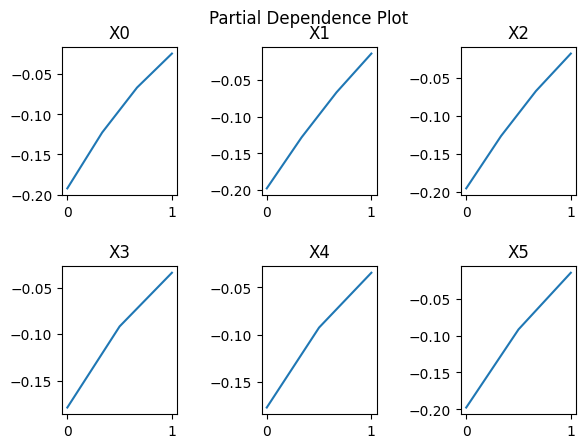

In [17]:
fig, ax = plt.subplots(2, 3)
fig.tight_layout(pad=3.0)

plt.suptitle('Partial Dependence Plot')
ax[0, 0].plot(torch.unique(torch.Tensor(data_input.iloc[:, 0])), avg_predictions_all_features[0])
ax[0, 0].set_title('X0')
ax[0, 1].plot(torch.unique(torch.Tensor(data_input.iloc[:, 1])), avg_predictions_all_features[1])
ax[0, 1].set_title('X1')
ax[0, 2].plot(torch.unique(torch.Tensor(data_input.iloc[:, 2])), avg_predictions_all_features[2])
ax[0, 2].set_title('X2')
ax[1, 0].plot(torch.unique(torch.Tensor(data_input.iloc[:, 3])), avg_predictions_all_features[3])
ax[1, 0].set_title('X3')
ax[1, 1].plot(torch.unique(torch.Tensor(data_input.iloc[:, 4])), avg_predictions_all_features[4])
ax[1, 1].set_title('X4')
ax[1, 2].plot(torch.unique(torch.Tensor(data_input.iloc[:, 5])), avg_predictions_all_features[5])
ax[1, 2].set_title('X5')

plt.show()

Wyniki uzyskane z Partial Dependence Plots pokrywają się z analizą wykonaną w poprzednim punkcie.

## Wyjaśnienie decyzji

In [18]:
chosen_variants_input = np.array([X_train[256], X_train[302], X_train[1000]])
chosen_variants_target = np.array([y_train[256], y_train[302], y_train[1000]])
print(chosen_variants_input.round(4))
print(chosen_variants_target)

[[0.     0.3333 0.     0.     0.5    1.     0.     0.     0.     0.
  0.     0.     0.     0.3333 0.3333 0.     0.     0.     0.     0.
  0.5   ]
 [0.     0.6667 1.     0.5    0.     0.5    0.     0.     0.     0.
  0.     0.6667 0.5    0.     0.5    0.5    0.     0.5    0.     0.5
  0.    ]
 [0.     0.3333 0.6667 0.5    0.     0.     0.     0.     0.     0.
  0.     0.3333 0.3333 0.     0.     0.5    0.     0.     0.     0.
  0.    ]]
[0 1 0]


Ze względu na występującą reprezentację Möbiusa, istotne są również zależności między kryteriami. Uważamy jednak, że zmiana wartości na 4 najistotniejszym kryterium na najlepszą możliwą ('1') pozwoli na zmianę klasyfikacji wariantów z klasy 'nieakceptowalny' na 'akceptowalny' dla modelu wykorzystującego całkę Choquet.

In [19]:
chosen_variants_input[0][3], chosen_variants_input[2][3] = 1, 1
y_probe = model(torch.Tensor(chosen_variants_input))
print((y_probe[:, 0] > 0).detach().numpy().astype(int))
print(y_probe)

[0 0 0]
tensor([[-0.2337],
        [-0.1465],
        [-0.3014]], grad_fn=<SubBackward0>)


Uzyskana zmiana okazała się niewystarczająca. Wynika to z zastosowania transformacji Möbiusa we wcześniejszym etapie - konieczność zmiany na etapie wczytywania danych, z następującą potem transformacją. Kolejną z przyczyn niepowodzenia mogą być zbliżone wpływy poszczególnych kryteriów na końcowy rezultat predykcji - konieczność zmiany wartości na więcej niż 1 kryterium.

## Złożony model sieci neuronowej z kilkowa warstwami ukrytymi

In [118]:
def calculate_metrics(dataset, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    probabilities = model.predict_proba(dataset)[:, 1]
    auc = roc_auc_score(y_true, probabilities)
    return accuracy, f1, auc

In [119]:
from sklearn.neural_network import MLPClassifier

hidden_layer_sizes = (15, 15, 15)

path = "data/car evaluation.csv"
data = pd.read_csv(path, header=None)
target_map = {1: 0, 2: 1, 3: 1, 4: 1}
criteria_nr = 6

data = data.drop_duplicates()
data_input = data.drop(columns=[criteria_nr])
data_target = data.iloc[:, criteria_nr].apply(lambda x: target_map[x])

X_train, X_test, y_train, y_test = train_test_split(
    data_input.values, data_target.values, test_size=0.2, random_state=1234
)

model = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

accuracy_train, f1_train, auc_train = calculate_metrics(X_train, y_train, y_pred_train)
accuracy_test, f1_test, auc_test = calculate_metrics(X_test, y_test, y_pred)

print("Training:")
print(f"Accuracy: {accuracy_train:.4f}")
print(f"F1 Score: {f1_train:.4f}")
print(f"AUC: {auc_train:.4f}")
print()

print("Test:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"F1 Score: {f1_test:.4f}")
print(f"AUC: {auc_test:.4f}")

Training:
Accuracy: 0.9696
F1 Score: 0.9492
AUC: 0.9948

Test:
Accuracy: 0.9451
F1 Score: 0.9116
AUC: 0.9944


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


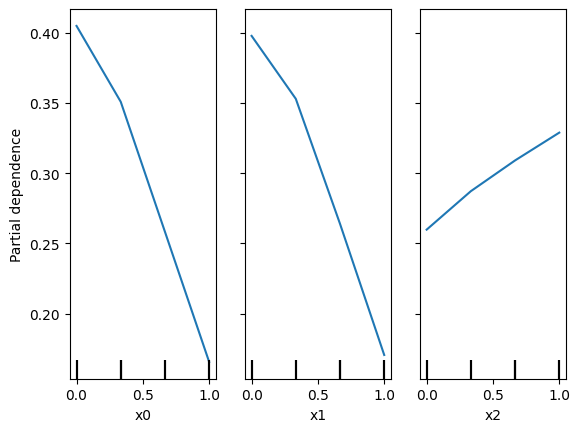

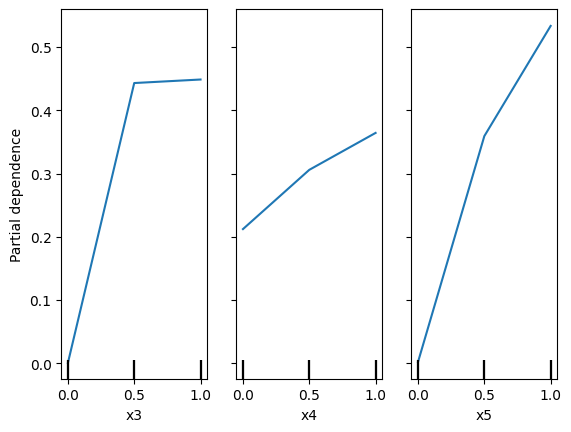

In [120]:
features_1 = [0, 1, 2]
PartialDependenceDisplay.from_estimator(model, X_train, features_1)
features_2 = [3, 4, 5]
PartialDependenceDisplay.from_estimator(model, X_train, features_2)

## Interpretacja modelu
Ze względu na niską interpretowalność modelu złożonej sieci neuronowej, składającej się z 3 warstw ukrytych z 15 wagami, jego interpretację zaczynamy tym razem od narysowania wykresów zależności cząstkowych. Jest on częściowo zgodny z wynikami uzyskanymi przy użyciu modelu rankSVM. Użytkownicy dokonują wyboru na podstawie głównie 4 z 6 kryteriów: kosztów zakupu i utrzymania, liczby osób, którą dane auto może pomieścić oraz najważniejszego - bezpieczeństwa. Uzyskano zdecydowanie najlepsze wartości metryk, które oznaczają że jest to model najdokładniejszy. Znikomy wpływ na podejmowane decyzje mają kryteria: liczba drzwi pojazdu oraz pojemność bagażu. Podobnie jak w przypadku wcześniejszych modeli nie sposób dostrzec jednoznacznie progi preferencji. Również istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji - wiele wariantów przypisanych do tej samej klasy decyzyjnej pomimo wystąpienia relacji dominacji w stosunku do innych wariantów z tej samej klasy.

## Wyjaśnienie decyzji

In [121]:
chosen_variants_input = np.array([X_train[256], X_train[267], X_train[300]])
chosen_variants_target = np.array([y_train[256], y_train[267], y_train[300]])
print(chosen_variants_input.round(4))
print(chosen_variants_target)

[[0.     0.3333 0.     0.     0.5    1.    ]
 [0.3333 1.     1.     0.     0.     1.    ]
 [0.6667 0.     0.6667 0.5    0.5    1.    ]]
[0 0 1]


Wszystkie rozpatrywane warianty mają najlepszą możliwą wartość uzyskaną dla najważniejszego kryterium - bezpieczeństwa. Uważamy zatem, że zmiana wartości na kryterium oznaczającym maksymalną liczbę osób, które dane auto może pomieścić, dla wariantów zaklasyfikowanych do klasy 'nieakceptowalny' z najgorszej na najlepszą ('0' na '1') wystarczy, by zaklasyfikować te warianty do klasy 'akceptowalny'.

In [122]:
chosen_variants_input[0][3], chosen_variants_input[1][3] = 1, 1
y_probe = model.predict(chosen_variants_input)
print(y_probe[0], y_probe[1]) 

1 1


Uzyskane wyniki zgadzają się z przewidywaniami teoretycznymi.

In [123]:
explainer = anchor_tabular.AnchorTabularExplainer(
    [0, 1],
    ['buying', 'maintenance', 'doors_number', 'persons_number', 'lug_boot', 'safety'],
    X_train)

In [124]:
for index in [256, 267, 300]:
    print(X_test[index].round(4))
    np.random.seed(1)
    print('Prediction: ', explainer.class_names[model.predict(X_test[index].reshape(1, -1))[0]])
    exp = explainer.explain_instance(X_test[index], model.predict, threshold=0.95)

    print('Anchor: %s' % (' AND '.join(exp.names())))
    print('Precision: %.2f' % exp.precision())
    print('Coverage: %.2f' % exp.coverage())

[0.6667 0.3333 0.6667 0.     0.5    0.5   ]
Prediction:  0
Anchor: persons_number <= 0.00
Precision: 1.00
Coverage: 0.33
[0.3333 0.3333 0.6667 0.5    1.     0.5   ]
Prediction:  1
Anchor: persons_number > 0.00 AND safety > 0.00 AND buying <= 0.33 AND lug_boot > 0.50
Precision: 1.00
Coverage: 0.07
[0.3333 1.     1.     1.     0.5    0.5   ]
Prediction:  0
Anchor: safety <= 0.50 AND maintenance > 0.67 AND lug_boot <= 0.50
Precision: 0.96
Coverage: 0.11


Jak można zauważyć, dla 3 wybranych wariantów spośród przyjmowanych przez nie wartości kryterium decydującym okazało się 'persons_number' oraz 'safety'.